In [2]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-b77d55jq
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-b77d55jq
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=a6b8ab23fba4e6ab64ddd7dc4df963ec78479f70fdf62e45b429376625299f2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jtzmlac6/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib
Note: you may need to restart the kernel to use updated packages.


In [3]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)
#axis = -1 to ensure that features are normalized per feature map

In [4]:
#loading the dataset
import os
import glob
from os import listdir
import numpy as np
from numpy import asarray
from numpy import vstack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
#load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
from random import random
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from numpy import zeros
from numpy import ones
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization


In [5]:

#the photos are of sqaure size 256*256
#we create an array of images for Category A and another for Category B. Both the arrays are then saved to a new file in compressed Numpy array format.

#loading all the images in a directory into memory.
def load_images(path, size=(256,256)):
    data_list = list()
    #list all the names of the files within the directory(enumerate)
    for filename in listdir(path):
        #load and resize the image
        pixels = load_img(path+filename, target_size=size)
        #now convert to numpy array
        pixels = img_to_array(pixels)
        #store to memory
        data_list.append(pixels)
        return asarray(data_list)
# path = '/kaggle/input/cyclegan/vangogh2photo/vangogh2photo/'
# #load Dataset A
# dataA1 = load_images(path + 'trainA/')
# dataA2 = load_images(path +'testA/')
# dataA = vstack((dataA1,dataA2))
# print('Dataset A loaded', dataA.shape)
# #load Dataset B
# dataB1 = load_images(path + 'trainB/')
# dataB2 = load_images(path +'testB/')
# dataB = vstack((dataB1,dataB2))
# print('Dataset A loaded', dataB.shape)
# #save as compressed numpy array
# filename = 'vangogh2photo_comp.npz'
# savez_compressed(filename, dataA,dataB)
# print('Saved Dataset:', filename)
# #the size is larger than the raw images as we are storing pixel values as 32-bit floating point values.




Loaded:  (800, 256, 256, 3) (7038, 256, 256, 3)


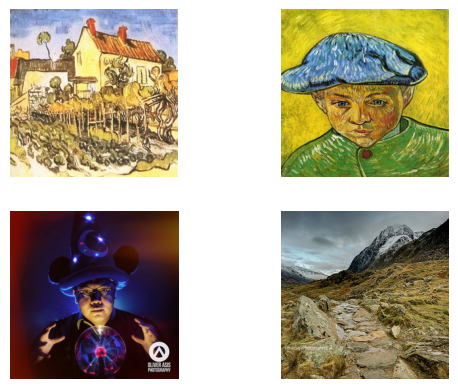

In [6]:
data = load('/kaggle/input/npzdata/vangogh2photo_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 2
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

# 2. Develop a Generative Model
### we have to create 4 models: 2 discriminator models, 2 generator models
*  the discriminator is a deep CNN network that performs image classification. It takes a source image as input and predicts the likelihood of whether the target image is real or fake.
* Discriminator design is based on the effective receptive field of the model which defines the relationship between one output of the model to the number of pixels in the input image.This is called a PatchGAN model and is carefully designed so that each output prediction of the model maps 70X70 squares or patch of the input image.The benefit of this is that it, this model can be applied to input images of different sizes, i.e that is larger or smaller than 256X256 pixels
* Unlike other models, the cycleGAN discriminator uses InstanceNormalisation instead of BatchNormalization.This involves standardizing(scaling to a standard guassian) the values on each output feature map,rather than across features in the batch. This can be accessed from the *keras contrib project*

## Discriminator Model

### This function implements the 70X70 patchGAN discriminator model. 
The model takes 256X256 sized image as input and outputs a patch of perdictions.
the model is optimized using least square loss (implemented as mean squared error), and a weighting is used so that the updates if the model have half (0.5)
the usual effect.(this was reccomended by the authors of the paper to slow down the changes to the discriminator relative to the generator 
                 model during training)

In [7]:
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev=0.02)
    #source image input
    in_image = Input(shape=image_shape)
    #64
    d = Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    #128
    d = Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    #256
    d = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    #512
    d = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d =InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    #prefinal output layer
    d = Conv2D(512,(4,4),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    #patch output
    patch_out = Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
    #definig the model
    model = Model(in_image,patch_out)
    #compiling the model
    model.compile(loss = 'mse',optimizer = Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
    return model

### Generator Model

* The generator is a encoder-decoder model architecture.
* The model takes a source image and generates a target image.
* It is done first by *downsampling(encoding)* the input down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use the skip connections.
* This step is then followed by a series of layers that *upsample(decoding)* the representation to the size of the output image

In [8]:
'''
The ResNet architecture allows for the training of very deep neural networks by introducing residual connections that skip some layers,
which helps prevent the vanishing gradient problem.
We first define the ResNet Blocks. These are blocks compromised of two 3X3 CNN layers where the input to the block is concatenated
to the output of the block, channel-wise.
This function creates 2 Convulation-InstanceNorm blocks with 3X3 filter and 1X1 stride.
Same padding is used instead of refelction padded reccomended in the paper.
'''
def resnet_block(n_filters,input_layer):
    init = RandomNormal(stddev=0.02)
    #1 convolution layer
    g = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    #2 convolution layer
    g = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    #concatenate merge channel-wise with the input layer
    g = Concatenate()([g,input_layer])
    return g

'''define a function that creates 9-ResNet block version for 256X256 input images. Importantly, the model outputs pixel values with the
shape as the input and pixel values are in the range [-1,1]

'''

def define_generator(image_shape,n_resnet=9):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    #c7s1-64 7x7 filter and stride of 1, with 64 output channels.
    g = Conv2D(64,(7,7),padding='same',kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    #d128
    g = Conv2D(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    #d256
    g = Conv2D(256,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    #R256 ResNet block with 256 output channels.
    for _ in range(n_resnet):
        g = resnet_block(256,g)
    '''Apply a series of transposed convolutional layers with Instance Normalization and ReLU activation,
    before outputting the generated image with the same shape as the input image.'''
    #u128 transposed convolutional layer with 128 output channels, and a stride of 2, which corresponds to upsampling the feature map
    g = Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    #u64
    g = Conv2DTranspose(64,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    #c7s1-3
    g = Conv2DTranspose(3,(7,7),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    '''tanh activation function is used for the output image to ensure pixel values are in the range of [-1,1].'''
    #define model
    model = Model(in_image,out_image)
    return model
    
    
    

## Loss Functions
* generator models are trained via their related discriminator models. They are updated to minimize the loss predicted by the discriminator for generated images marked as 'real' called as *adverserial loss*.
* generator model should also be good at regenerating the source image when used with the generator model called the *cycle loss*
* generator model is expected to output an image without translation when provided with an example from target domain called as *identity loss*

The 4 loss functions we will be considering are:
1. Adverserial loss (L2, mean squared error)
2. Identity loss (L1, mean absolute error)
3. Forward Cycle loss (L1, Mean absolute error)
4. Bakward Cycle loss (L1 or mean absolute error)

**we need to create a COMPOSITE MODEL to train each generator and share weights with related discriminator and other generator model**

In [9]:
'''In the composite model the weights of the other model are marked as not trainable as we are interested in updating the first generator
model,i.e focus in the composite model
- discriminator is connected to the output of the generator to classify the images as real or fake.
-  second input for the composite model is defined as an image from the target domain(instead of the source domain),which the generator is 
expected to output without the translation for the identity mapping.
- Forward Cycle Loss involves connecting the output of the generator to the other generator,which will reconstruct source image.
- Backward Cycle loss involves the image from the target domain used for the identity mapping then is also passed through the other 
generator whose output is connected to our main generator as input and outputs a reconstructed version of that image from a target domain.

Hence, 2 inputs and 4 outputs.

Only weights of the first or main generator models are updated for the composite model as this is done by weighted sum of all loss 
functions.
Cycle loss has more weight than adverserial loss in the paper(10 times)
'''
def define_composite_model(g_model_1,d_model,g_model_2,image_shape):
    #ensure the model we are updating is trainable
    g_model_1.trainable = True
    #mark discriminator as non-trainable
    d_model.trainable = False
    g_model_2.trainable = False
    #discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    #identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    #forward cycle
    output_f = g_model_2(gen1_out)
    #backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    #define the model graph
    model = Model([input_gen,input_id],[output_d,output_id,output_f,output_b])
    #optimization algorithm
    opt = Adam(lr=0.0002,beta_1=0.5)
    #model compile
    model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],optimizer=opt)
    return model

### Generator A Composite Model (BtoA)
1. Adversarial Loss: Domain-B -> Generator-A -> Domain-A -> Discriminator-A -> [real/fake]
2. Identity Loss: Domain-A -> Generator-A -> Domain-A
3. Forward Cycle Loss: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
4. Backward Cycle Loss: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A

- Inputs: Domain-B, Domain-A
- Outputs: Real, Domain-A, Domain-B, Domain-A



In [10]:
'''Load paired images dataset in Numpy array format, it will return list of 2 numpy arrays'''
def load_real_samples(filename):
    data = load(filename)
    #unpack the arrays
    X1,X2 = data['arr_0'],data['arr_1']
    #scaling from [0,255] to [-1,1]
    X1 = (X1-127.5)/127.5
    X2 = (X2 - 127.5)/127.5
    return X1,X2

#selecting random batch of images for every iteration
'''This is implemented by taking the np array for a domain as input and returning the requested number of randomly selected
images, as well as the target for the PatchGAN dicriminator model indicating the images are real(target_value = 1.0)
'''

def generate_real_samples(dataset,n_samples,patch_shape):
    ix = randint(0,dataset.shape[0],n_samples)
    #retreive selected images
    X = dataset[ix]
    # generate 'real class labels (1)'
    y = ones((n_samples,patch_shape,patch_shape,1)) #this is 16X16X1 activation map
    return X,y

def generate_fake_samples(g_model,dataset,patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X),patch_shape,patch_shape,1))
    return X,y

'''GAN models dont converge, it finds an equilibrium in generator and discriminator, so we cannot judge when the training should stop.
So we save the model and use to it to generate sample image to image translations periodically during training
'''

def save_models(step,g_model_AtoB,g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5'%(step+1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('...Saved: %s and %s'%(filename1,filename2))
    
# this function uses given generator model to generate translated versions of randomly selected images and saves the plot to file
def summarize_performance(step,g_model,trainX,name,n_samples=5):
    #select sample of input images
    X_in, _ = generate_real_samples(trainX,n_samples,0)
    #generate translated images
    X_out,_ = generate_fake_samples(g_model,X_in,0)
    #scale all pixels from [-1,1] to [0,1]
    X_in = (X_in +1)/2.0
    X_out = (X_out +1)/2.0
    #plot real images
    for i in range(n_samples):
        pyplot.subplot(2,n_samples,1+i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    #plot for translated imafes
    for i in range(n_samples):
        pyplot.subplot(2,n_samples,1+n_samples+i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    #save the plot to file
    outputphotos = '/kaggle/working/outputphotos/'
    if not os.path.exists(outputphotos):
        os.makedirs(outputphotos)
    filename1 = outputphotos+'%s_generated_plot_%06d.png'%(name,(step+1))
    pyplot.savefig(filename1)
    pyplot.close()
    
# to manage how quickly discriminator model learns a pool of fake images is maintained
'''In the paper they define an image pool of 50 generated images for each discriminator model that is first populated and
probabilistically either adds new images to the pool by replacing an exisitng images or uses a generated image directly.
'''
def update_image_pool(pool,images,max_size=50):
    selected = list()
    for image in images:
        if len(pool)<max_size:
            #stock the pool
            pool.append(image)
            selected.append(image)
        elif random()< 0.5:
            #use the image but dont add it to the pool
            selected.append(image)
        else:
            #replace an exisitng image and use replaced image
            ix = randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix]=image
        return asarray(selected)

## Model Training

In [11]:
'''Arguements-> 6 models: 2 discriminator,2 generator, 2 composite models and dataset.Model would be saved for every 5 epochs'''

def train(d_model,d_model_B,g_model_AtoB,g_model_BtoA,c_model_AtoB,c_model_btoA,dataset):
    n_epochs ,n_batch = 100,1
    #output square shape fo the discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack the dataset
    trainA,trainB = dataset
    #image pool for fakes
    poolA,poolB = list(),list()
    #calculate number od batches per training epoch
    bat_per_epo = int(len(trainA)/n_batch)
    #no. of training iterations
    n_steps = bat_per_epo*n_epochs
    #enumerate the epochs
    for i in range(n_steps):
        #selecting the batch of real samples
        X_realA, y_realA = generate_real_samples(trainA,n_batch,n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        #update the fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        # remove previously saved models
        # remove previously saved models
        if (i+1) % (bat_per_epo * 5) == 0:
            # remove previously saved models
            for file_name in glob.glob("g_model_AtoB_*.h5"):
                os.remove(file_name)
            for file_name in glob.glob("g_model_BtoA_*.h5"):
                os.remove(file_name)
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)





In [ ]:
# load image data
dataset = load_real_samples('vangogh2photo_comp.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)


## Image translation

In [19]:
# load dataset
A_data, B_data = load_real_samples('/kaggle/input/npzdata/vangogh2photo_256.npz')
print('Loaded', A_data.shape, B_data.shape)

Loaded (800, 256, 256, 3) (7038, 256, 256, 3)


In [21]:
# load the models
from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/kaggle/input/models4000/g_model_AtoB_004000.h5', cust)
model_BtoA = load_model('/kaggle/input/models4000/g_model_BtoA_004000.h5', cust)

In [22]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [23]:
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)

1/1 [==============================] - 3s 3s/step


In [24]:
# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

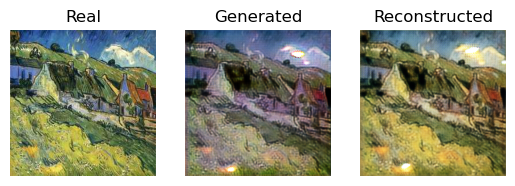

In [25]:
show_plot(A_real, B_generated, A_reconstructed)

1/1 [==============================] - 2s 2s/step


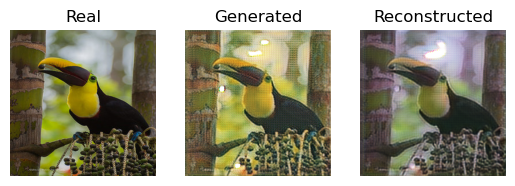

In [26]:
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

Loaded (800, 256, 256, 3) (7038, 256, 256, 3)
1/1 [==============================] - 3s 3s/step


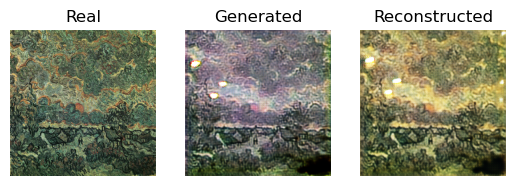

1/1 [==============================] - 2s 2s/step


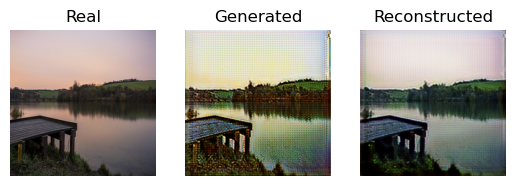

In [27]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
A_data, B_data = load_real_samples('/kaggle/input/npzdata/vangogh2photo_256.npz')
print('Loaded', A_data.shape, B_data.shape)
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/kaggle/input/models4000/g_model_AtoB_004000.h5', cust)
model_BtoA = load_model('/kaggle/input/models4000/g_model_BtoA_004000.h5', cust)
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

1/1 [==============================] - 3s 3s/step


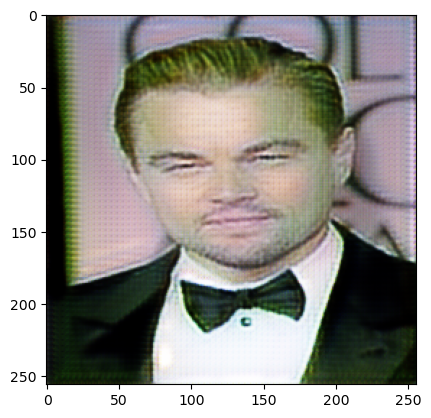

In [28]:
# example of using saved cyclegan models for image translation
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from matplotlib import pyplot

# load an image to the preferred size
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

# load the image
image_src = load_image('/kaggle/input/dicaprio/licensed-image.jpeg')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/kaggle/input/models4000/g_model_AtoB_004000.h5', cust)
# translate image
image_tar = model_AtoB.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow_addons.layers import InstanceNormalization
import numpy as np
from PIL import Image

def load_image(img):
    with open(img.name, 'rb') as f:
        img_data = f.read()
    return img_data

def translate_image(image):
    # load the model
    cust = {'InstanceNormalization': InstanceNormalization}
    model_AtoB = load_model('/kaggle/input/models4000/g_model_AtoB_004000.h5', cust)
    # convert to numpy array
    image_np = np.array(image)
#     image = Resizing(256, 256)(image)
    # normalize pixels
    image_np = (image_np - 127.5) / 127.5
    # add batch dimension
    image_np = np.expand_dims(image_np, axis=0)
    # translate image
    image_tar = model_AtoB.predict(image_np)
    # scale from [-1,1] to [0,1]
    image_tar = (image_tar + 1) / 2.0
    # convert back to PIL image
    image_tar = (image_tar[0] * 255).astype(np.uint8)
    image_tar = Image.fromarray(image_tar)
    return image_tar



# create the interface
input_image = gr.inputs.Image(type="pil")
output_image = gr.outputs.Image(type="pil")

iface = gr.Interface(fn=translate_image, inputs=input_image, outputs=output_image, 
                     title="Image-to-Image Translation", 
                     description="Translate an image from one domain to another using CycleGAN")

iface.launch()
